In [30]:
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.preprocessing import MinMaxScaler
from scipy.io import arff
from scipy.spatial.distance import pdist, squareform
import pandas as pd
import numpy as np


In [31]:

def load_data(path):
    data = arff.loadarff(path)

    return pd.DataFrame(data[0])

In [32]:
def process_data(raw_df):
    scaler = MinMaxScaler()

    raw_X = raw_df.drop(columns=['defects'])

    scaled_X_data = scaler.fit_transform(raw_X.values)

    X = pd.DataFrame(scaled_X_data, index=raw_X.index, columns=raw_X.columns)

    raw_df['defects'] = raw_df['defects'].apply(lambda i: b'true' == i)

    y = raw_df['defects']

    return X, y, raw_df

In [33]:
def get_knn(k=None, **kwargs):
    return KNeighborsClassifier(n_neighbors=k, algorithm='brute', weights='uniform', metric='euclidean', **kwargs)

def get_knn_weighted(k=None, **kwargs):
    return KNeighborsClassifier(n_neighbors=k, algorithm='brute', weights='distance', metric='euclidean', **kwargs)

def get_knn_adaptive(radius_series, distances):
    def calc_distance(x,y):
        print(f'{x=}', f'{y=}')
        print(x.name, y.name)
        exit()
    return KNeighborsClassifier(algorithm='brute', weights='distance', metric=calc_distance)

In [34]:
def grid_search(X, y, knn=None):

    param_grid = { 'n_neighbors': [1,2,3,5,7,9,11,13,15] }

    scoring = {'accuracy' : make_scorer(accuracy_score), 
            'precision' : make_scorer(precision_score),
            'recall' : make_scorer(recall_score), 
            'f1_score' : make_scorer(f1_score)}

    knn_gscv = GridSearchCV(knn, param_grid, cv=5, scoring=scoring, refit='accuracy')

    knn_gscv.fit(X, y)

    return knn_gscv

0000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.92864031e-03, 6.77984709e-04, 3.84615385e-01, 1.59020434e-02,
       1.97493871e-02, 1.07814928e-05, 0.00000000e+00, 1.07814927e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.22535211e-02, 3.18471338e-03, 2.38095238e-03, 1.22850123e-03,
       0.00000000e+00]) y=array([2.36966825e-04, 4.21052632e-03, 1.37931034e-02, 6.45161290e-03,
       1.44648023e-04, 7.59156005e-05, 1.00000000e+00, 1.03363282e-02,
       4.42658676e-03, 6.03615014e-07, 2.27670753e-01, 1.08650702e-05,
       2.50000000e-02, 5.89970501e-03, 1.21951220e-02, 1.00000000e+00,
       2.81690141e-03, 3.82165605e-03, 1.58730159e-04, 1.47420147e-03,
       2.48447205e-03])
x=array([0.38862559, 0.29473684, 0.89655172, 0.33870968, 0.53857281,
       0.5018319 , 0.01538462, 0.33998569, 0.68435031, 0.17061249,
       0.50087566, 0.17061253, 0.7625    , 0.09439528, 0.29268293,
       0.        , 0.43661972, 0.55414013, 0.51746032, 0.571253

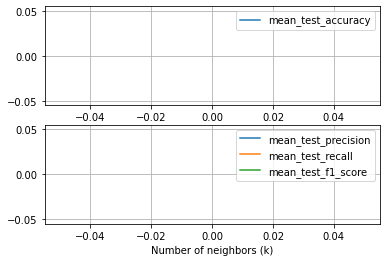

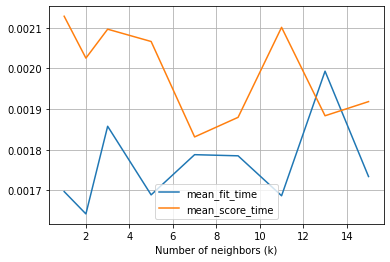

In [35]:
def plot_search_results(grid, title):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    import matplotlib.pyplot as plt
    results = grid.cv_results_
    fig, axs = plt.subplots(2)
    # fig.suptitle(title, fontsize=16)
    axs[0].plot('param_n_neighbors', 'mean_test_accuracy', data=results)
    # axs[0].set_xticks([1,2,3,5,7,9,11,13,15])
    # axs[0].set_yticks(np.arange(0.83, 0.91, 0.01))
    axs[0].grid()
    axs[0].set_xlabel('Number of neighbors (k)')
    axs[0].legend()

    axs[1].plot('param_n_neighbors', 'mean_test_precision', data=results)
    axs[1].plot('param_n_neighbors', 'mean_test_recall', data=results)
    axs[1].plot('param_n_neighbors', 'mean_test_f1_score', data=results)
    axs[1].grid()
    axs[1].set_xlabel('Number of neighbors (k)')
    # axs[1].set_xticks([1,2,3,5,7,9,11,13,15])
    # axs[1].set_yticks(np.arange(0, 0.35, 0.03))
    axs[1].legend()

    # fig.show()
    fig.savefig(title + '.png')

    import matplotlib.pyplot as plt
    fig1, axs1 = plt.subplots()
    axs1.plot('param_n_neighbors', 'mean_fit_time', data=results)
    axs1.plot('param_n_neighbors', 'mean_score_time', data=results)
    # ax2.set_xticks([1,2,3,5,7,9,11,13,15])
    # ax2.set_yticks(np.arange(0.83, 0.91, 0.01))
    axs1.grid()
    axs1.set_xlabel('Number of neighbors (k)')
    axs1.legend()

    # fig.show()
    fig1.savefig(title + 'time.png')

def get_distances_by_index(X1):
    return pd.DataFrame(
        squareform(pdist(X1)),
        columns = X1.index,
        index = X1.index
    )

def get_radius_for_adaptive(distances):
    raw_true = raw[raw['defects'] == True]
    true_indexes = raw_true.index.values.tolist()

    raw_false = raw[raw['defects'] == False]
    false_indexes = raw_false.index.values.tolist()

    for i in true_indexes:
        for j in false_indexes:
            distances.at[i, j] = float('inf')
            distances.at[j, i] = float('inf')

    for i in range(len(raw.index)):
        distances.at[i, i] = float('inf')
        
    return distances.min()

## CM1
# X1, y1, raw = process_data(load_data('./data/cm1.arff'))

# distances = get_distances_by_index(X1)
# radius = get_radius_for_adaptive(distances)

# # Standard knn
# knn_gscv_cm1 = grid_search(X1, y1, get_knn())
# plot_search_results(knn_gscv_cm1, 'cm1-standard')

# # Weighted knn
# weighted_knn_gscv_cm1 = grid_search(X1, y1, get_knn_weighted())
# plot_search_results(weighted_knn_gscv_cm1, 'cm1-weighted')

# Adaptive knn
# adaptive_knn_gscv_cm1 = grid_search(X1, y1, get_knn_adaptive(radius, distances))
# plot_search_results(adaptive_knn_gscv_cm1, 'cm1-weighted')


## JM1
X1, y1, raw = process_data(load_data('./data/kc1.arff'))
# Standard knn
knn_gscv_kc1 = grid_search(X1, y1, get_knn())
plot_search_results(knn_gscv_kc1, 'kc1-standard')
kc1_std_res = knn_gscv_kc1.cv_results_

# Weighted knn
weighted_knn_gscv_kc1 = grid_search(X1, y1, get_knn_weighted())
plot_search_results(weighted_knn_gscv_kc1, 'kc1-weighted')
kc1_w_res = weighted_knn_gscv_kc1.cv_results_